In [1]:
import pandas as pd
import numpy as np
import requests
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

# Prepare Data

## Import

In [2]:
load_dotenv()
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

In [3]:
def get_daily(ticker, output_size="full", data_type="json"):
    
    url = (
    "https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
    f"apikey={api_key}"
    )
    
    response = requests.get(url=url)
    
    response_data = response.json()
    
    stock_data = response_data["Time Series (Daily)"]
    df = pd.DataFrame.from_dict(stock_data, orient="index", dtype="float")
    
    df.index = pd.to_datetime(df.index)
    df.index.name = "date"
    
    df.columns = [c.split(". ")[1] for c in df.columns]
    
    return df

In [4]:
def wrangle_data(dataframe):
    
    df = dataframe
    
    df.sort_index(ascending=True, inplace=True)
    
    df['return'] = df['close'].pct_change() * 100
    
    return df['return'].dropna()

In [5]:
df_apple = get_daily(ticker="NVDA")

In [6]:
print(df_apple.shape)
df_apple.info()
df_apple.head()

(6277, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6277 entries, 2024-10-11 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6277 non-null   float64
 1   high    6277 non-null   float64
 2   low     6277 non-null   float64
 3   close   6277 non-null   float64
 4   volume  6277 non-null   float64
dtypes: float64(5)
memory usage: 294.2 KB


,open,high,low,close,volume
date,,,,,
2024-10-11,134.01,135.78,133.66,134.80,170209474.0
2024-10-10,131.91,135.00,131.00,134.81,242311337.0
2024-10-09,134.11,134.52,131.38,132.65,246191612.0
2024-10-08,130.26,133.48,129.42,132.89,285722485.0
2024-10-07,124.99,130.64,124.95,127.72,346250233.0


# Explore

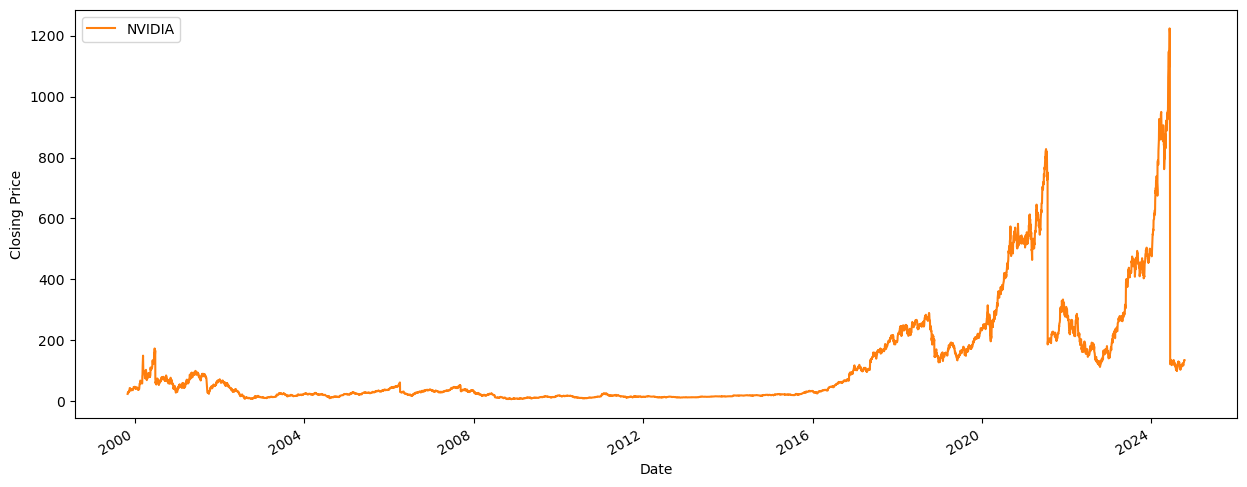

In [7]:
fig, ax = plt.subplots(figsize=(15,6))
#plot 'df_apple' close price
df_apple['close'].plot(ax=ax, label='NVIDIA', color='C1')

#label axes
plt.xlabel('Date')
plt.ylabel('Closing Price')

#add legend
plt.legend();

In [8]:
#Procceding with the APPLE stock data
df_apple = wrangle_data(dataframe=df_apple)

In [9]:
df_apple.head()

date
1999-11-02    6.382979
1999-11-03    9.760000
1999-11-04    6.377551
1999-11-05   -3.220281
1999-11-08    2.867257
Name: return, dtype: float64

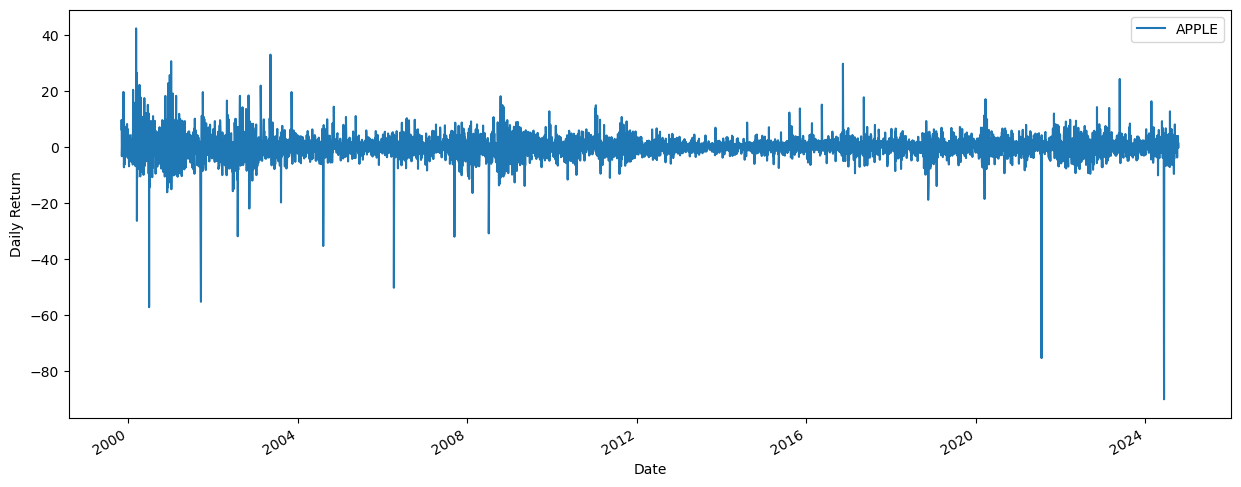

In [10]:
#plotting the return
fig, ax = plt.subplots(figsize=(15,6))

df_apple.plot(ax=ax, label='APPLE', color='C0')

#label axes
plt.xlabel('Date')
plt.ylabel('Daily Return')

#add legend
plt.legend();

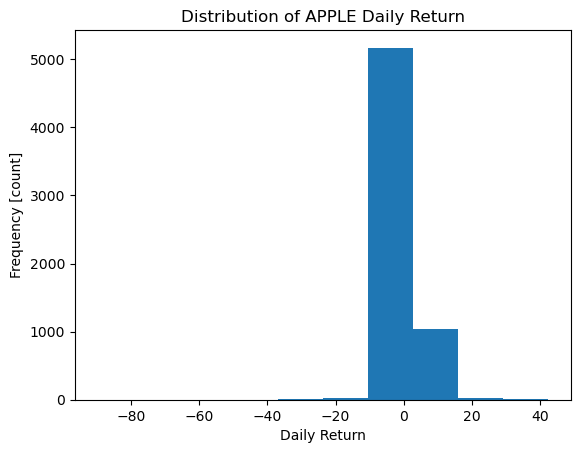

In [11]:
#create histogram of "APPLE"
plt.hist(df_apple)

#add axes
plt.xlabel('Daily Return')
plt.ylabel('Frequency [count]')

#title
plt.title("Distribution of APPLE Daily Return");

In [12]:
#Daily Volatility of APPLE
apple_daily_volatility = df_apple.std()
print("APPLE Daily Volatility", apple_daily_volatility)

APPLE Daily Volatility 4.231200573206072


In [13]:
#Annual Volatility of APPLE
apple_annual_volatility = apple_daily_volatility * np.sqrt(252)  #excepted trading days in American stock market is '252'
print("APPLE Annual Volatility", apple_annual_volatility)

APPLE Annual Volatility 67.16822678362328


In [14]:
#volatility of 50-days window
apple_rolling_50d_volatility = df_apple.rolling(window=50).std().dropna()
print("rolling_volatility type", type(apple_rolling_50d_volatility))
apple_rolling_50d_volatility

rolling_volatility type <class 'pandas.core.series.Series'>


date
2000-01-12    5.055845
2000-01-13    5.019315
2000-01-14    4.886142
2000-01-18    4.848068
2000-01-19    4.818026
                ...   
2024-10-07    4.172830
2024-10-08    4.198679
2024-10-09    4.059027
2024-10-10    3.659296
2024-10-11    3.516835
Name: return, Length: 6227, dtype: float64

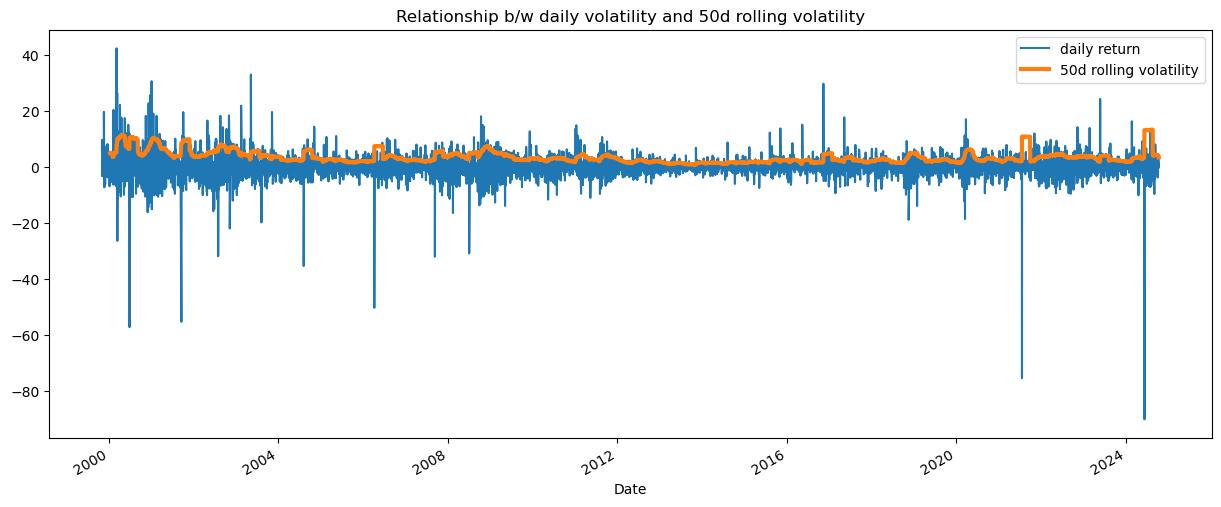

In [15]:
fig, ax= plt.subplots(figsize=(15,6))

#plot daily volatiliy
df_apple.plot(ax=ax, label='daily return')

#plot 50d rolling volatility
apple_rolling_50d_volatility.plot(ax=ax, label='50d rolling volatility', linewidth=3)

#add axes
plt.xlabel('Date')
plt.title("Relationship b/w daily volatility and 50d rolling volatility")

#add legend
plt.legend();

creating a time series plot of the squared return in apple return

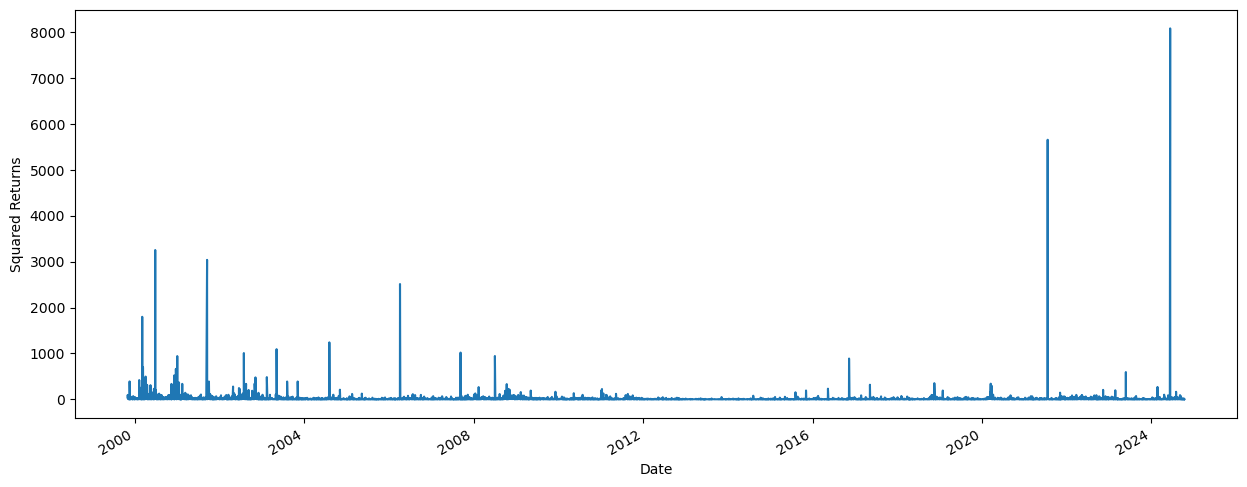

In [16]:
fig, ax = plt.subplots(figsize=(15,6))

#squared return
(df_apple**2).plot(ax=ax)

#add axes
plt.xlabel('Date')
plt.ylabel('Squared Returns');

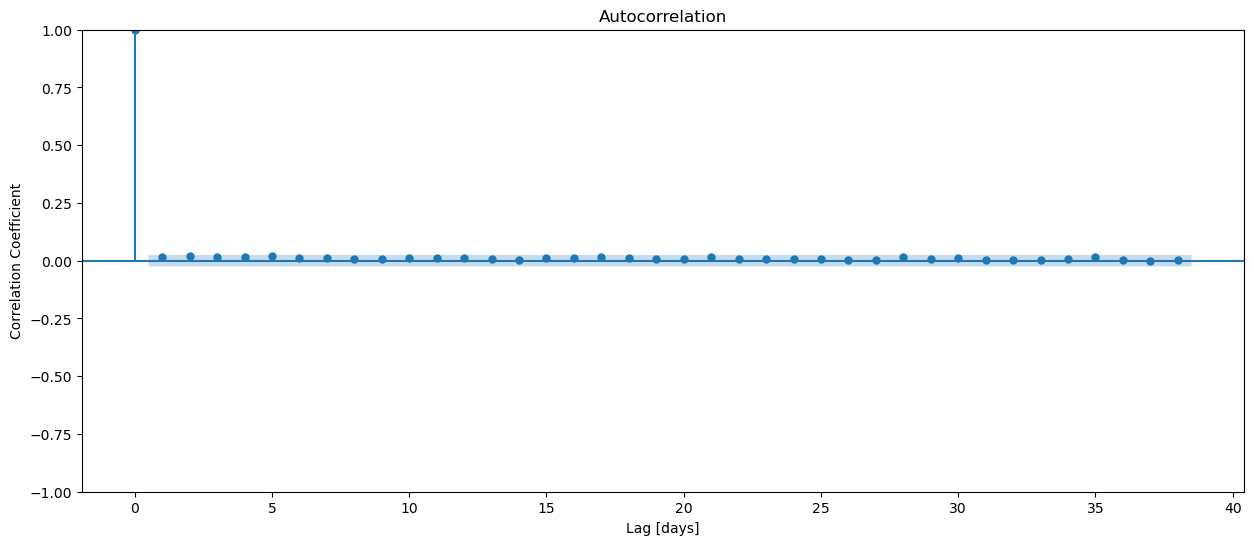

In [17]:
#create ACF plot
fig, ax = plt.subplots(figsize=(15,6))

#ACF of squared returns
plot_acf((df_apple.dropna()**2), ax=ax)

#add axes
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient');

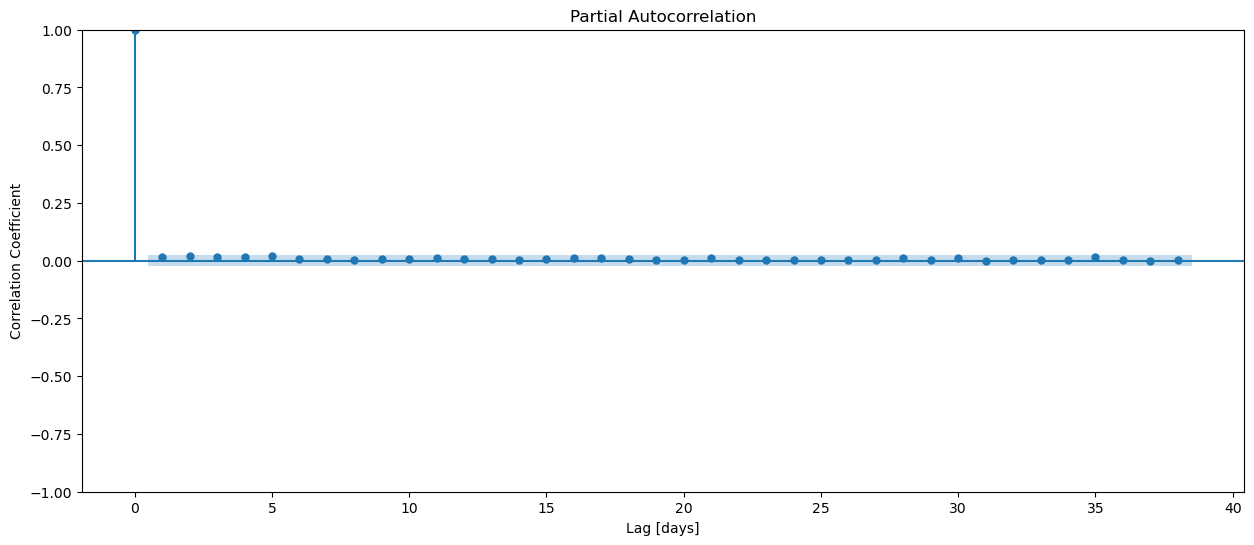

In [18]:
#create PACF plot
fig, ax = plt.subplots(figsize=(15,6))

#ACF of squared returns
plot_pacf((df_apple.dropna()**2), ax=ax)

#add axes
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient');

# Split

In [19]:
int(len(df_apple) * 0.8)

5020

In [20]:
cutoff_test = int(len(df_apple) * 0.8)
df_apple_train = df_apple.iloc[:cutoff_test]

print("df_apple_train shape:", df_apple_train.shape)
df_apple_train.tail()

df_apple_train shape: (5020,)


date
2019-10-09    1.963550
2019-10-10    1.283825
2019-10-11    1.617221
2019-10-14    0.290338
2019-10-15    5.275291
Name: return, dtype: float64

# Build Model

## Iteration

In [21]:
model = arch_model(
    df_apple_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("model type:", type(model))

model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13459.7
Distribution:                  Normal   AIC:                           26927.3
Method:            Maximum Likelihood   BIC:                           26953.4
                                        No. Observations:                 5020
Date:                Mon, Oct 14 2024   Df Residuals:                     5019
Time:                        08:44:16   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1395  8.822e-02      1.581      0.114 [-3.340e-02,  0.312]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2497      0.199      1.255      0.210    [ -0.140,  0.640]
alpha[1]       0.0984  5.054e-02      1.948  5.142e-02 [-6.059e-04,  0.198]
beta[1]        0.9016  4.775e-02     18.879  1.701e-79    [  0.808,  0.995]
===========================================================================

Covariance estimator: robust
"""

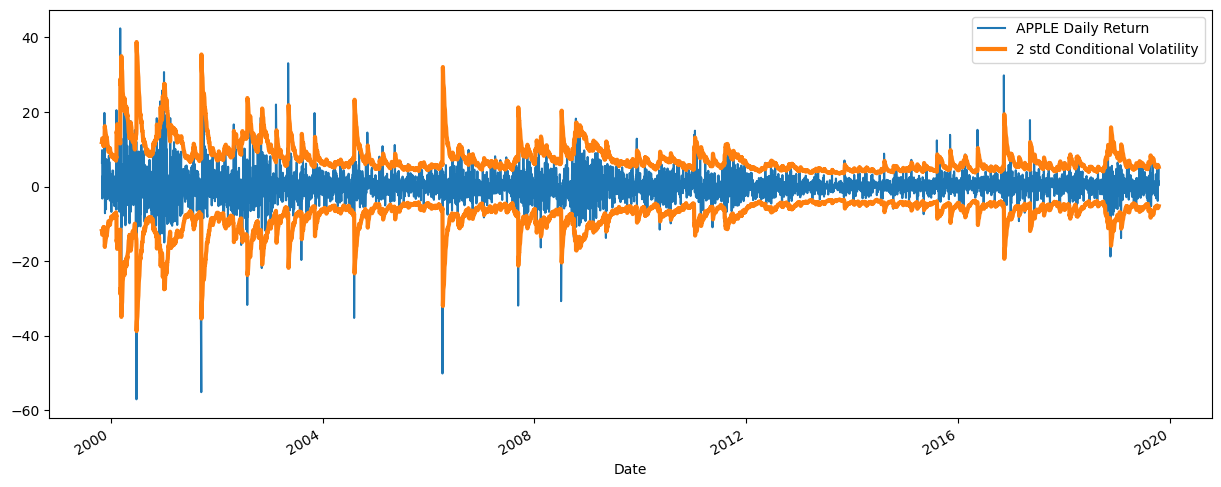

In [22]:
fig, ax=plt.subplots(figsize=(15,6))

df_apple_train.plot(ax=ax, label="APPLE Daily Return")

# plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, label="2 std Conditional Volatility", linewidth=3, color="C1"
)

# plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, linewidth=3, color="C1"
)

# add axis labels
plt.xlabel("Date")

# add legend
plt.legend();

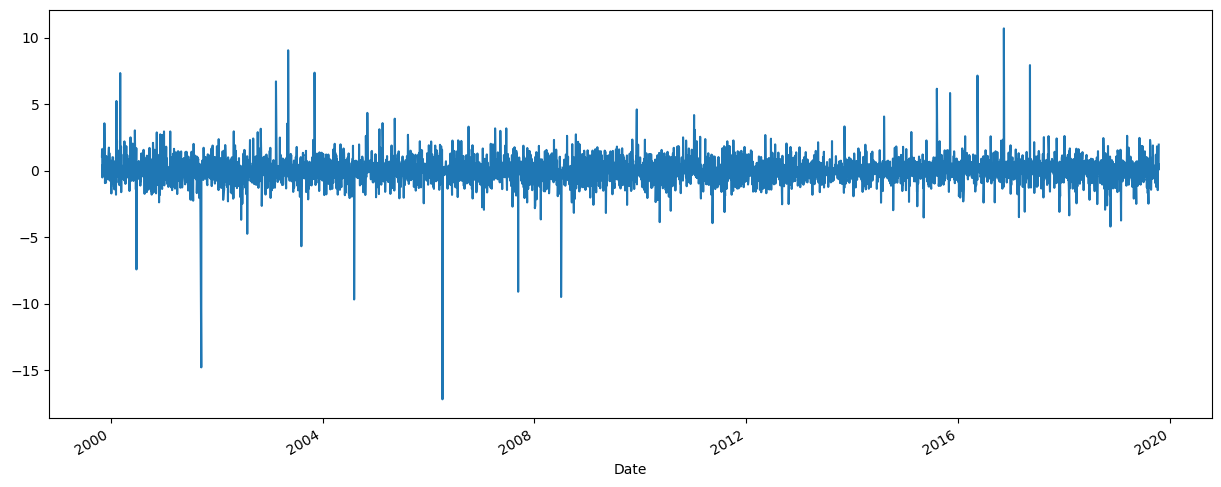

In [23]:
fig, ax=plt.subplots(figsize=(15,6))

# plot standarized residuals
model.std_resid.plot(ax=ax, label="standarized residuals")
# add axis labels
plt.xlabel('Date')
# add legend
plt.legend;

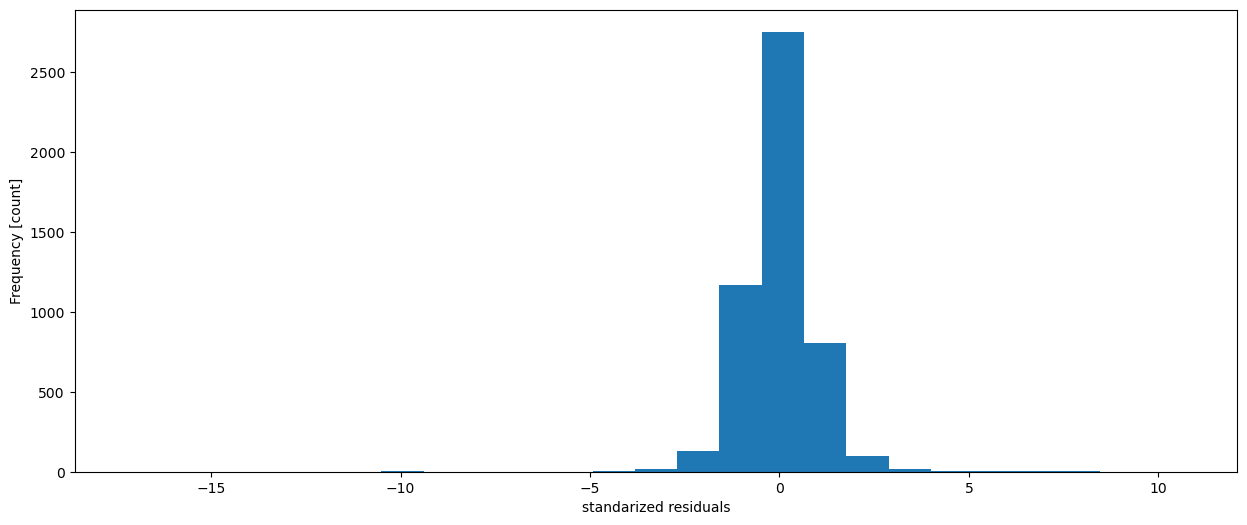

In [24]:
fig, ax=plt.subplots(figsize=(15,6))

# histogram of standarized residuals
plt.hist(model.std_resid, bins=25)

# add axis label
plt.xlabel('standarized residuals')
plt.ylabel('Frequency [count]')

# add legend
plt.legend;

Text(0.5, 0, 'Lag [days]')

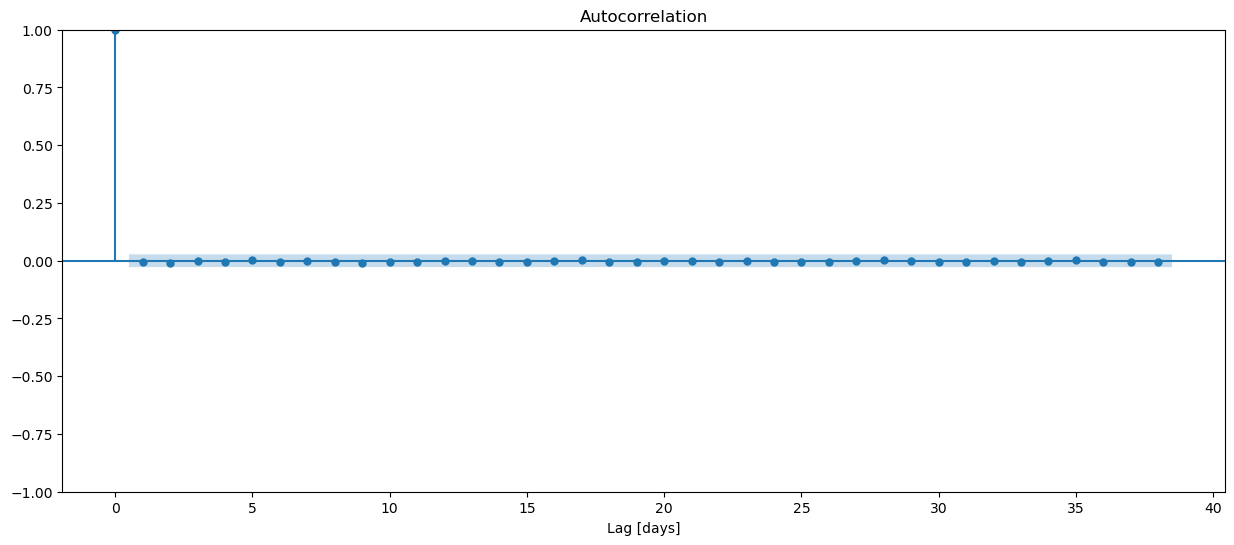

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")


# Evaluation

In [26]:
df_apple_train.tail(1)

date
2019-10-15    5.275291
Name: return, dtype: float64

In [27]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance
print("one day forecast type:", type(one_day_forecast))
one_day_forecast

one day forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2019-10-15,9.117814


In [28]:
one_day_forecast.iloc[0,0]**0.5

3.019571895340001

## Performing Walk forward Validation

In [29]:
prediction = []

test_size = int(len(df_apple) * 0.2)

#walk forward
for i in range(test_size):
    y_train = df_apple.iloc[: -(test_size - i)]
    
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)
    
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5
    
    prediction.append(next_pred)
    
y_test_wfv = pd.Series(prediction, index=df_apple.tail(test_size).index)

print("y_test_wfv type", type(y_test_wfv))
print("y_test_wfv shape", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type <class 'pandas.core.series.Series'>
y_test_wfv shape (1255,)


date
2019-10-17    2.935743
2019-10-18    2.831744
2019-10-21    2.812550
2019-10-22    2.851131
2019-10-23    2.754787
dtype: float64

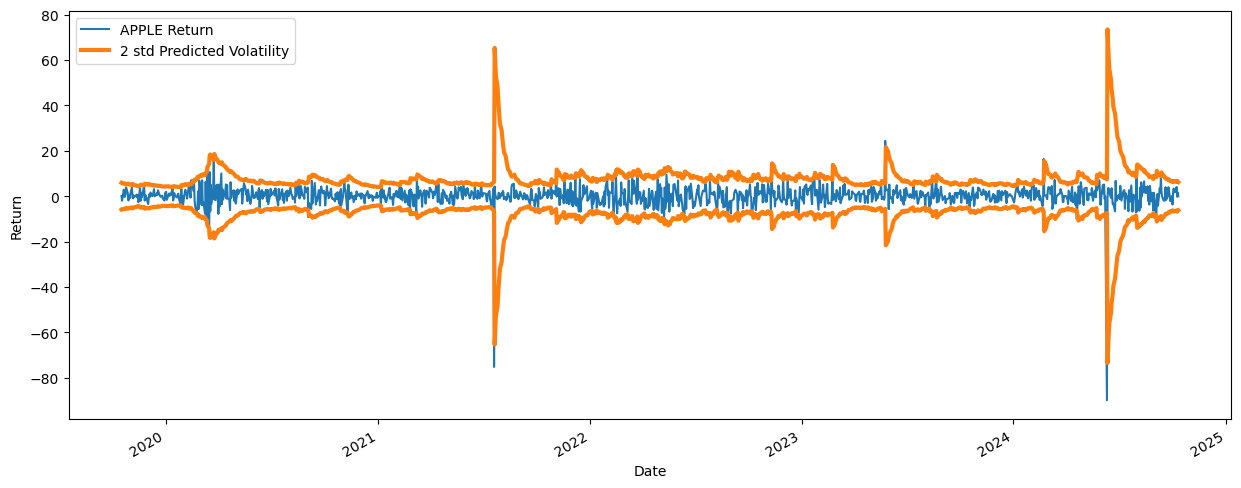

In [30]:
fig, ax=plt.subplots(figsize=(15,6))

df_apple.tail(test_size).plot(ax=ax, label="APPLE Return")

# plot conditional volatility * 2
(2 * y_test_wfv).plot(
    ax=ax, label="2 std Predicted Volatility", linewidth=3, color="C1"
)

# plot conditional volatility * -2
(-2 * y_test_wfv).plot(
    ax=ax, linewidth=3, color="C1"
)

# add axis labels
plt.xlabel("Date")
plt.ylabel("Return")

# add legend
plt.legend();

# Communicate Results

In [31]:
#create 5-days volatility forecast
predictions = model.forecast(horizon=5, reindex=False).variance ** 0.5

start = predictions.index[0] + pd.DateOffset(days=1)

prediction_dates = pd.bdate_range(start=start, periods=predictions.shape[1])

prediction_index = [d.isoformat() for d in prediction_dates]

In [32]:
print("prediction_index type", type(prediction_index))
print("prediction_index len", len(prediction_index))
prediction_index[:3]

prediction_index type <class 'list'>
prediction_index len 5


['2024-10-11T00:00:00', '2024-10-14T00:00:00', '2024-10-15T00:00:00']

In [33]:
def clean_prediction(predictions):
    
    start = predictions.index[0] + pd.DateOffset(days=1)

    prediction_dates = pd.bdate_range(start=start, periods=predictions.shape[1])

    prediction_index = [d.isoformat() for d in prediction_dates]
    
    data = predictions.values.flatten() ** 0.5
    
    prediction_formated = pd.Series(data, index=prediction_index)
    
    return prediction_formated.to_dict()

In [34]:
prediction_formatted = clean_prediction(predictions)
prediction_formatted

{'2024-10-11T00:00:00': 1.7621757589021505,
 '2024-10-14T00:00:00': 1.7933534375203048,
 '2024-10-15T00:00:00': 1.822984939982363,
 '2024-10-16T00:00:00': 1.8512381539314802,
 '2024-10-17T00:00:00': 1.878253984434361}